## YOLO Predictions

### 1. Image object detection

In [20]:
import cv2
import numpy as np
import pytesseract as pt
import os
import matplotlib.pyplot as plt
pt.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract' 

In [22]:
## Setting for the image
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 640
img = cv2.imread("./test_images/getty_sample.jpg")

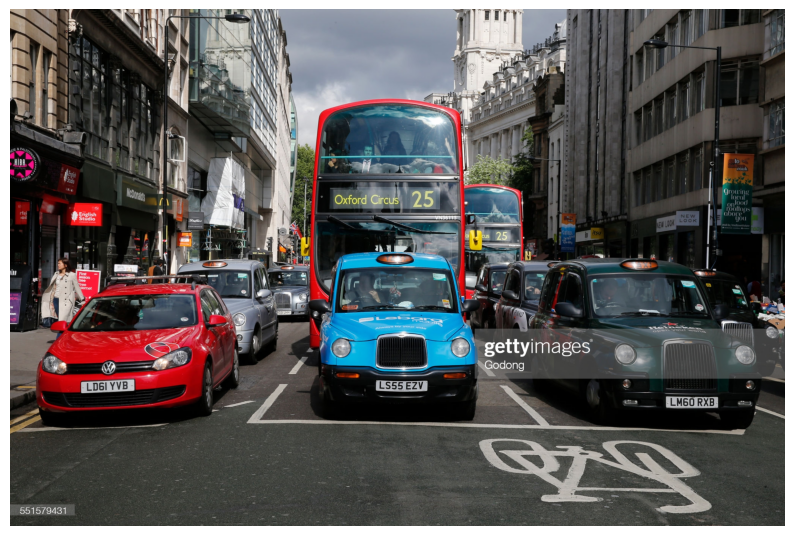

In [23]:
## Load the image using cv2

# cv2.imshow("test image",img)
# v2.waitKey(0)
# cv2.destroyAllWindows()

## Load the image using matplotlib
results_org_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 8))
plt.imshow(results_org_rgb)
plt.axis("off")   # Hide axis
plt.show()

In [33]:
## Load Yolo Model
net = cv2.dnn.readNetFromONNX("./trained_model/best.onnx")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [34]:
##Convert YOLO to image format
image = img.copy()
row, col, d = image.shape

max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
input_image[0:row,0:col] = image

#GET Prediction from Yolo model
blob = cv2.dnn.blobFromImage(input_image,1/255,(IMAGE_WIDTH,IMAGE_HEIGHT),swapRB=True,crop=False)
net.setInput(blob)
prediction = net.forward()
detection_boxes = prediction[0]
detection_boxes.shape

(25200, 6)

In [35]:
prediction.shape

(1, 25200, 6)

In [36]:
## Filter the detection boxes based on the confidence and probability score
# the detection score has the below values
#Example: [5.84833050e+00 8.47999763e+00 1.23947735e+01 1.72278805e+01 7.69723192e-06 9.99994159e-01]
# Center_x of the bounding box = 5.84833050e+00
# Center_y of the bounding box = 8.47999763e+00
# Width of the bounding box = 1.23947735e+01
# Height of the bounding box = 1.72278805e+01
# Confidence score = 7.69723192e-06
# Probability score = 9.99994159e-01
import easyocr

reader = easyocr.Reader(['en'])

def get_detections(img,net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(IMAGE_WIDTH,IMAGE_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

##NON Maximum Supression => to supress Yolo to create multiple bounding in the same region this is the limitation of Yolo. NMS help to remove repeated bounding box
def non_maximum_supression(input_image,detections):
    # FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/IMAGE_WIDTH
    y_factor = image_h/IMAGE_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten()
    
    return boxes_np, confidences_np, index

def extract_text(image,bbox, model="tesseract"):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    text = ""
    if 0 in roi.shape:
        return ''
    else:
        if model=="easyocr":
          results = reader.readtext(roi)
          for (bbox, text, prob) in results:
            text = text.strip()
        else:
          text = pt.image_to_string(roi)
          text = text.strip()

        return text

def drawings(image,boxes_np,confidences_np,index):
    # drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind],"easyocr")


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [37]:
# predictions
def yolo_predictions(img,net):
  ## step-1: detections
  input_image, detections = get_detections(img,net)
  ## step-2: NMS
  boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
  ## step-3: Drawings
  result_img = drawings(img,boxes_np,confidences_np,index)
  return result_img

In [38]:
# test
img = cv2.imread('./test_images/getty_sample.jpg')
results = yolo_predictions(img,net)
results_rgb = cv2.cvtColor(results, cv2.COLOR_BGR2RGB)

##### a. Show in cv2

In [ ]:
cv2.namedWindow('results',cv2.WINDOW_KEEPRATIO)
cv2.imshow('results',results)
cv2.waitKey(0)
if key == 27 or key == ord("q"):
  cv2.destroyAllWindows()

#### b. Show in metplotlib

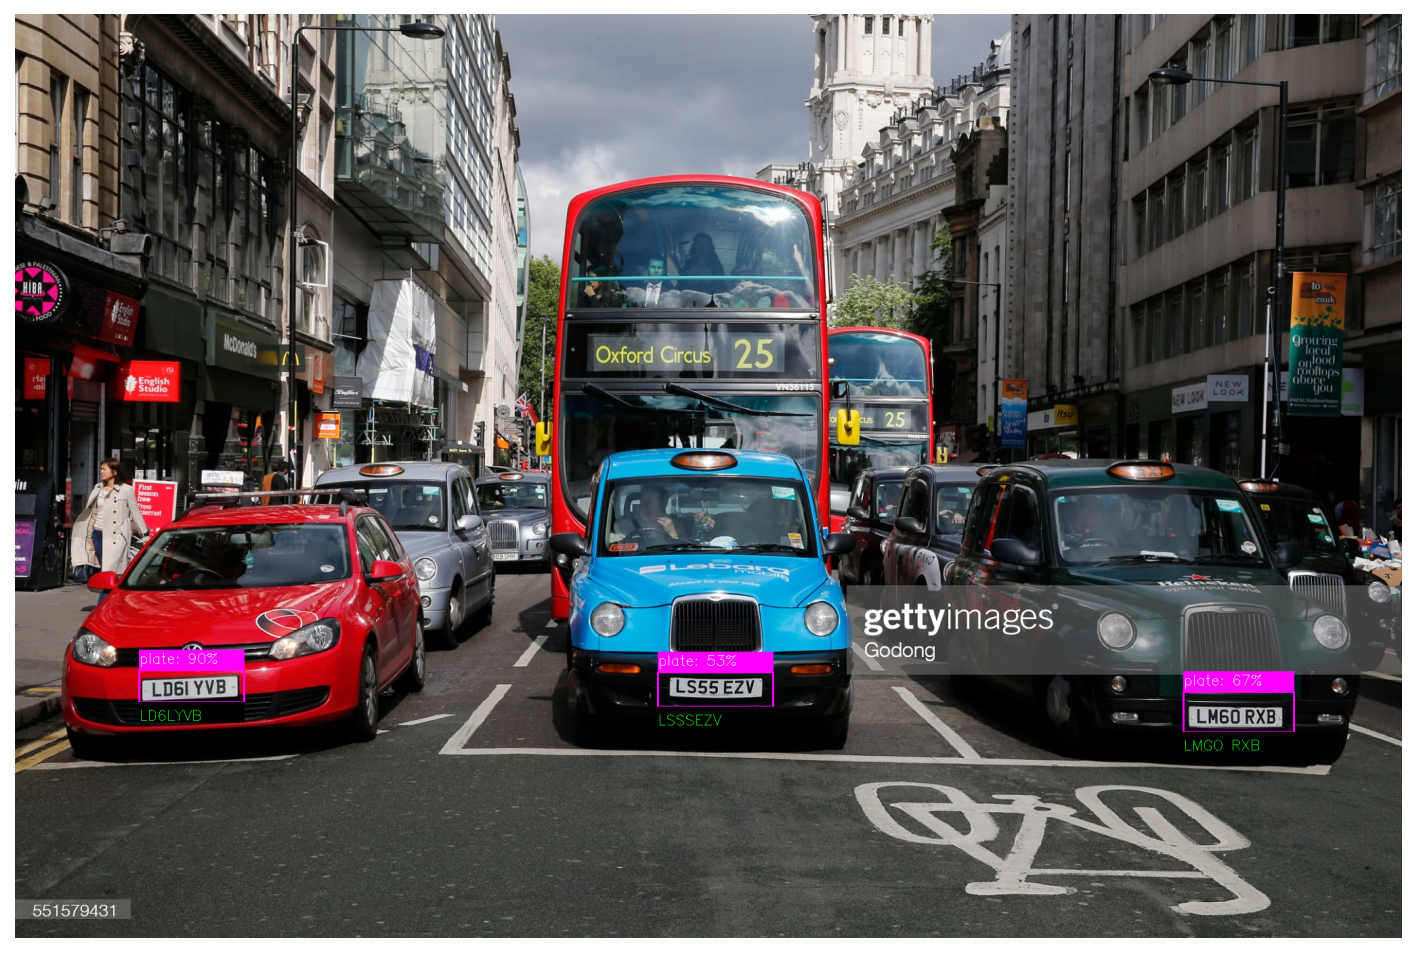

In [39]:
plt.figure(figsize=(12, 8), dpi=150)
plt.imshow(results_rgb)
plt.axis("off")   # Hide axis
plt.show()

### Real time(video) object detection

#### a. Show in cv2

In [ ]:
cap = cv2.VideoCapture("./test_images/traffic.mp4")

while True:
  ret, frame = cap.read()
  results = yolo_predictions(frame,net)

  if ret == False:
    print("unable to read video")
    break

  cv2.namedWindow('video traffic detection',cv2.WINDOW_KEEPRATIO)
  cv2.imshow('video traffic detection',results)
  if cv2.waitKey(1) & 0xFF == 27:  # ESC key
    break

cv2.destroyAllWindows()
cap.release()

: 

#### b. Show in Jupyter cell

In [11]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

cap = cv2.VideoCapture("./test_images/traffic.mp4")

while True:
    ret, frame = cap.read()
    if not ret:
        print("unable to read video")
        break

    results = yolo_predictions(frame, net)

    # Convert BGR → RGB
    results_rgb = cv2.cvtColor(results, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)

    # Show at higher quality
    plt.figure(figsize=(12, 8), dpi=150)  # bigger size + higher resolution
    plt.imshow(results_rgb)
    plt.axis("off")
    plt.show()

cap.release()

KeyboardInterrupt: 